In [1]:
!pip install tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 200.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 257.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 256.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 265.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 637.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 253.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 258.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 747.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 215.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 257.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 172.6 M

/opt/conda/lib/python3.11/site-packages/tabpfn/base.py:89: UserWarning: Downloading model to /tmp/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]


Classification Report (Test Set):

               precision    recall  f1-score   support

    0–2.8 hrs       0.71      0.41      0.52        58
  2.8–9.5 hrs       0.79      0.60      0.68       195
 9.5–11.0 hrs       0.54      0.73      0.62       268
11.0–14.0 hrs       0.67      0.66      0.67       316
14.0–20.8 hrs       0.50      0.18      0.26        17
    20.8+ hrs       0.85      0.82      0.84       279

     accuracy                           0.69      1133
    macro avg       0.68      0.57      0.60      1133
 weighted avg       0.70      0.69      0.69      1133



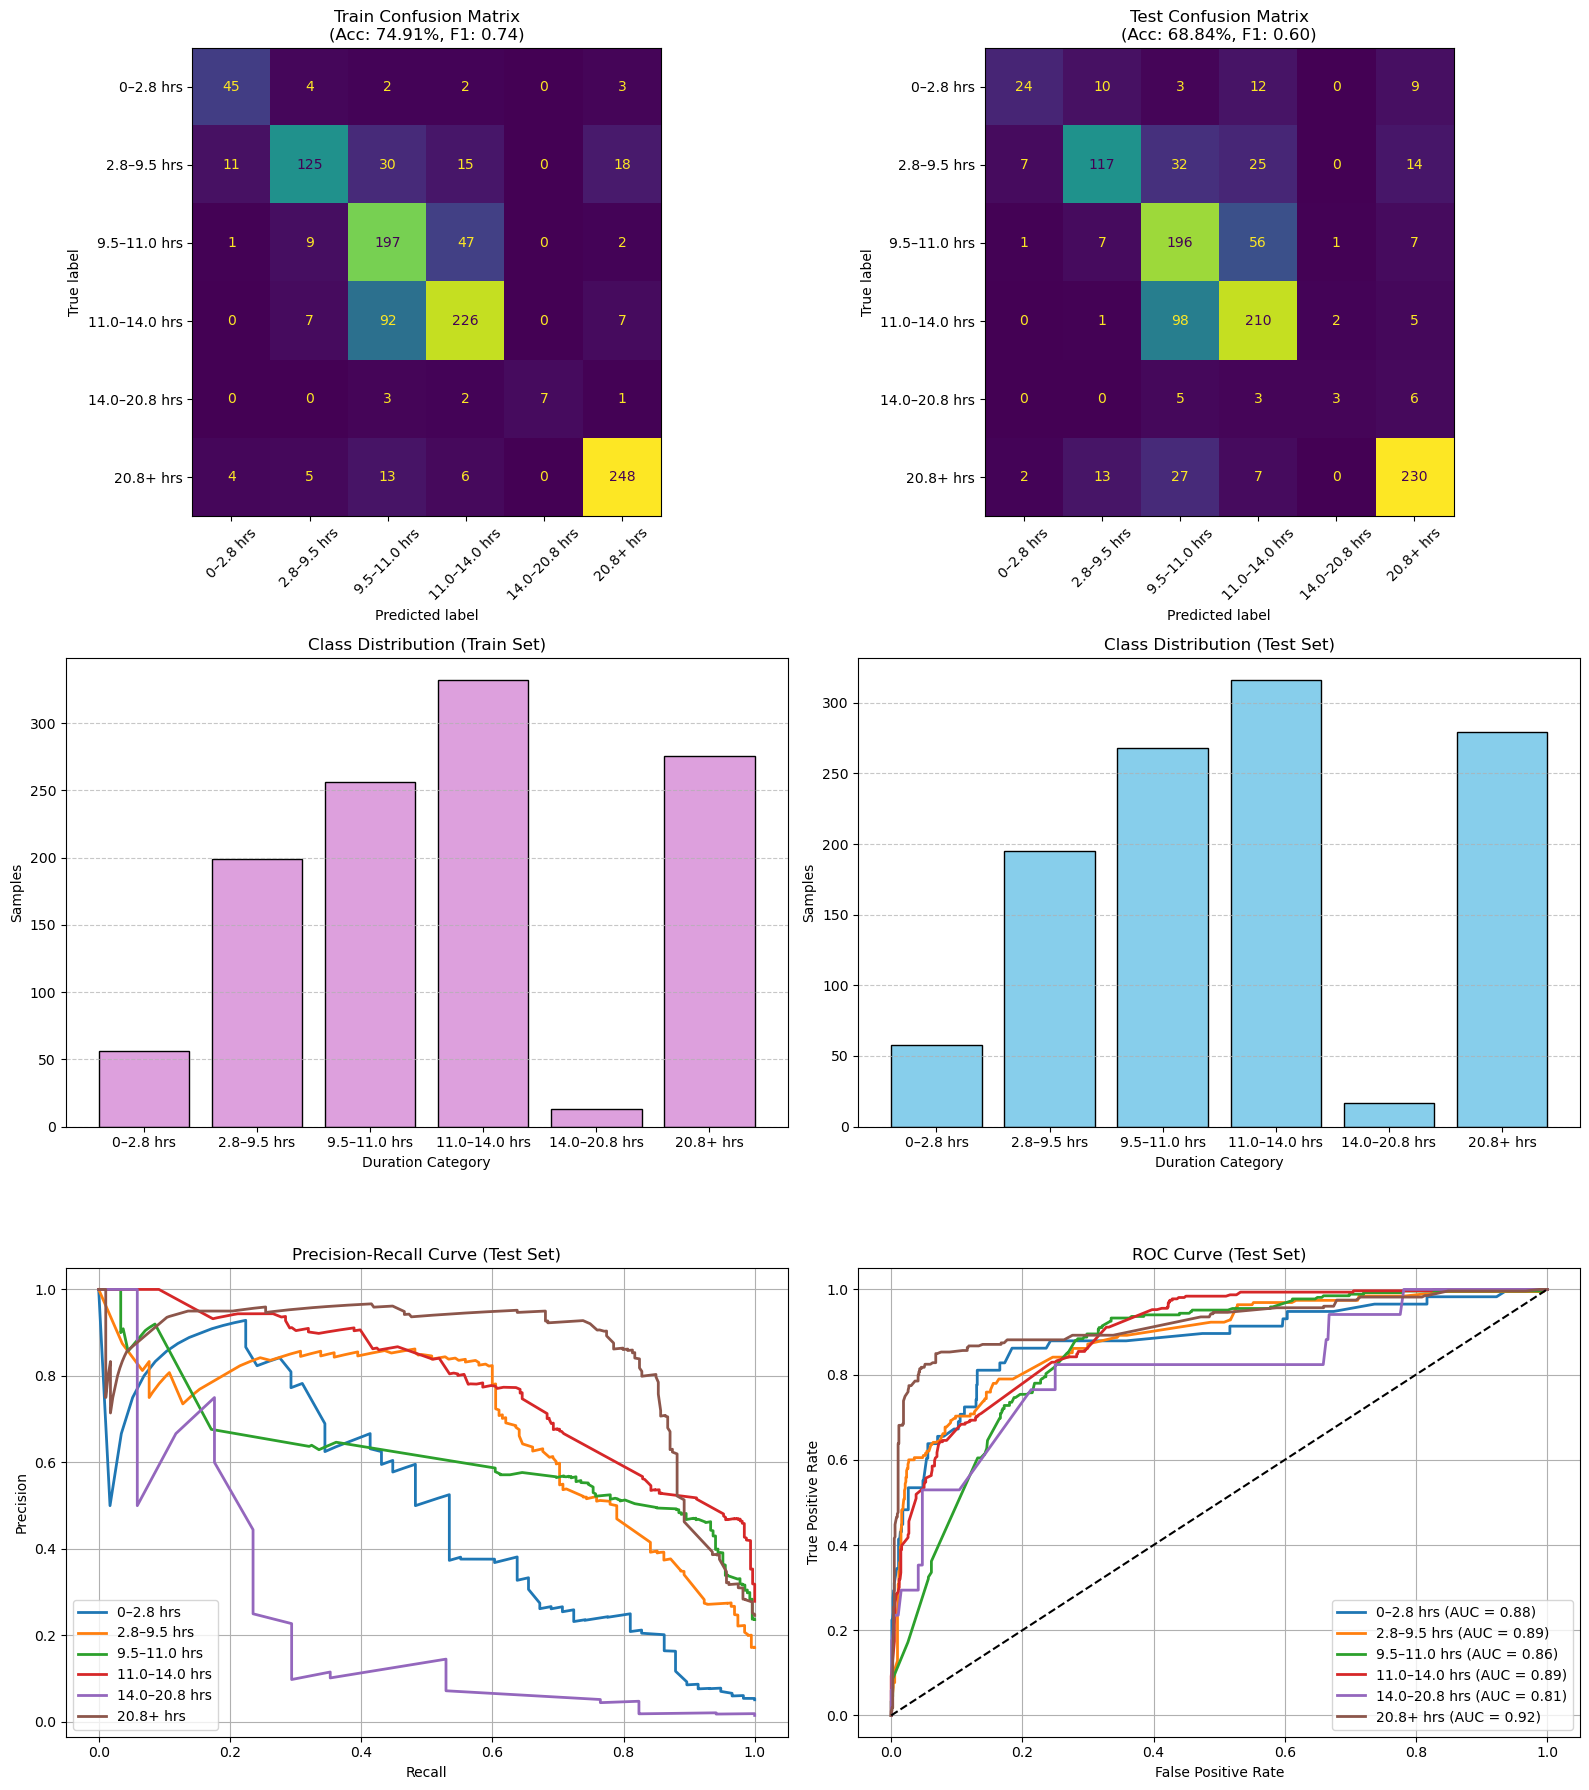

In [2]:
# --- Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from tabpfn import TabPFNClassifier

# Set display
pd.set_option('display.max_columns', None)

# --- Load data ---
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])

# --- Define duration order ---
duration_order = [
    '0–2.8 hrs', 
    '2.8–9.5 hrs', 
    '9.5–11.0 hrs', 
    '11.0–14.0 hrs', 
    '14.0–20.8 hrs', 
    '20.8+ hrs'
]

# Apply categorical type
df['Duration_Category'] = pd.Categorical(df['Duration_Category'], categories=duration_order, ordered=True)

# Manual mapping for encoding
category_to_int = {cat: idx for idx, cat in enumerate(duration_order)}
int_to_category = {idx: cat for cat, idx in category_to_int.items()}

# --- Feature/target setup ---
features = ['Recall_Day_Hours', 'Recall_Night_Hours',
            'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
            'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
target = 'Duration_Category'

df = df.dropna(subset=features + [target])

# Encode features
X = df[features].copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = pd.factorize(X[col])[0]

# Encode target with correct order
y = df[target].map(category_to_int).values

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# --- Train TabPFN model ---
clf = TabPFNClassifier(device="cuda")
clf.fit(X_train, y_train)

# --- Predictions ---
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# --- Scores ---
train_acc = accuracy_score(y_train, train_preds)
train_f1 = f1_score(y_train, train_preds, average="macro")
test_acc = accuracy_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds, average="macro")

# --- Classification report ---
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, test_preds, target_names=duration_order))

# --- Binarize y for PR/ROC ---
y_test_bin = label_binarize(y_test, classes=list(int_to_category.keys()))
n_classes = y_test_bin.shape[1]

# --- 3x2 Plot Grid ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Row 1: Confusion Matrices ---
# Train
train_cm = confusion_matrix(y_train, train_preds, labels=range(len(duration_order)))
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=duration_order)
disp_train.plot(cmap='viridis', ax=axes[0, 0], xticks_rotation=45, colorbar=False)
axes[0, 0].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%}, F1: {train_f1:.2f})")

# Test
test_cm = confusion_matrix(y_test, test_preds, labels=range(len(duration_order)))
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=duration_order)
disp_test.plot(cmap='viridis', ax=axes[0, 1], xticks_rotation=45, colorbar=False)
axes[0, 1].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%}, F1: {test_f1:.2f})")

# --- Row 2: Class Distributions ---
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[1, 0].bar(
    [duration_order[i] for i in train_counts.index], 
    train_counts.values, color='plum', edgecolor='black'
)
axes[1, 0].set_xlabel('Duration Category')
axes[1, 0].set_ylabel('Samples')
axes[1, 0].set_title('Class Distribution (Train Set)')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

test_counts = pd.Series(y_test).value_counts().sort_index()
axes[1, 1].bar(
    [duration_order[i] for i in test_counts.index], 
    test_counts.values, color='skyblue', edgecolor='black'
)
axes[1, 1].set_xlabel('Duration Category')
axes[1, 1].set_ylabel('Samples')
axes[1, 1].set_title('Class Distribution (Test Set)')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# --- Row 3: PR and ROC ---
# Precision-Recall
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    axes[2, 0].plot(recall, precision, lw=2, label=f'{duration_order[i]}')
axes[2, 0].set_xlabel('Recall')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].set_title('Precision-Recall Curve (Test Set)')
axes[2, 0].legend(loc='lower left')
axes[2, 0].grid()

# ROC
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    axes[2, 1].plot(fpr, tpr, lw=2, label=f'{duration_order[i]} (AUC = {roc_auc:.2f})')
axes[2, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
axes[2, 1].set_xlabel('False Positive Rate')
axes[2, 1].set_ylabel('True Positive Rate')
axes[2, 1].set_title('ROC Curve (Test Set)')
axes[2, 1].legend(loc='lower right')
axes[2, 1].grid()

# --- Layout ---
plt.tight_layout()
plt.show()

In [4]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    precision_recall_curve, roc_curve, auc, accuracy_score, f1_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_and_evaluate_tabpfn(region_df, feature_cols, target_col):
    """
    Train TabPFNClassifier and plot evaluation metrics for a given region DataFrame.
    """
    # Correct duration category order
    full_label_order = [
        '0–2.8 hrs', '2.8–9.5 hrs', '9.5–11.0 hrs',
        '11.0–14.0 hrs', '14.0–20.8 hrs', '20.8+ hrs'
    ]
    label_indices = list(range(len(full_label_order)))
    category_to_int = {cat: i for i, cat in enumerate(full_label_order)}
    int_to_category = {i: cat for i, cat in enumerate(full_label_order)}

    # Drop missing
    region_df = region_df.dropna(subset=feature_cols + [target_col])

    # Encode features
    X = region_df[feature_cols].copy()
    for col in X.select_dtypes(include='object').columns:
        X[col] = pd.factorize(X[col])[0]

    # Encode target using manual mapping
    region_df[target_col] = pd.Categorical(region_df[target_col], categories=full_label_order, ordered=True)
    y = region_df[target_col].map(category_to_int).values

    # Remove classes with <2 samples
    class_counts = pd.Series(y).value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = np.isin(y, valid_classes)
    X, y = X[mask], y[mask]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    clf = TabPFNClassifier(device='cuda')
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="macro", zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average="macro", zero_division=0)

    # Print report
    print("\nClassification Report (Test Set):")
    print(classification_report(
        y_test, y_test_pred,
        labels=label_indices,
        target_names=full_label_order,
        zero_division=0
    ))

    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # Row 1: Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=label_indices)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=full_label_order)
    disp_train.plot(cmap='viridis', ax=axes[0, 0], xticks_rotation=45, colorbar=False)
    axes[0, 0].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%}, F1: {train_f1:.2f})")

    cm_test = confusion_matrix(y_test, y_test_pred, labels=label_indices)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=full_label_order)
    disp_test.plot(cmap='viridis', ax=axes[0, 1], xticks_rotation=45, colorbar=False)
    axes[0, 1].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%}, F1: {test_f1:.2f})")

    # Row 2: Class Distributions
    train_counts = pd.Series(y_train).value_counts().reindex(label_indices, fill_value=0)
    test_counts = pd.Series(y_test).value_counts().reindex(label_indices, fill_value=0)

    axes[1, 0].bar(full_label_order, train_counts.values, color='plum', edgecolor='black')
    axes[1, 0].set_title("Train Class Distribution")
    axes[1, 0].set_xlabel("Class")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1, 1].bar(full_label_order, test_counts.values, color='skyblue', edgecolor='black')
    axes[1, 1].set_title("Test Class Distribution")
    axes[1, 1].set_xlabel("Class")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Row 3: PR / ROC
    y_test_bin = label_binarize(y_test, classes=label_indices)

    for i in label_indices:
        if i >= y_score.shape[1]:
            continue
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        axes[2, 0].plot(recall, precision, lw=2, label=full_label_order[i])
    axes[2, 0].set_title("Precision-Recall Curve (Test Set)")
    axes[2, 0].set_xlabel("Recall")
    axes[2, 0].set_ylabel("Precision")
    axes[2, 0].legend(loc='lower left')
    axes[2, 0].grid()

    for i in label_indices:
        if i >= y_score.shape[1]:
            continue
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        axes[2, 1].plot(fpr, tpr, lw=2, label=f'{full_label_order[i]} (AUC = {roc_auc:.2f})')
    axes[2, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
    axes[2, 1].set_title("ROC Curve (Test Set)")
    axes[2, 1].set_xlabel("False Positive Rate")
    axes[2, 1].set_ylabel("True Positive Rate")
    axes[2, 1].legend(loc='lower right')
    axes[2, 1].grid()

    plt.tight_layout()
    plt.show()

    return clf



--- Region: SA ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.67      0.80      0.73         5
  2.8–9.5 hrs       1.00      0.82      0.90        11
 9.5–11.0 hrs       0.00      0.00      0.00         2
11.0–14.0 hrs       0.50      0.20      0.29         5
14.0–20.8 hrs       0.00      0.00      0.00         2
    20.8+ hrs       0.91      1.00      0.95        59

     accuracy                           0.87        84
    macro avg       0.51      0.47      0.48        84
 weighted avg       0.84      0.87      0.85        84



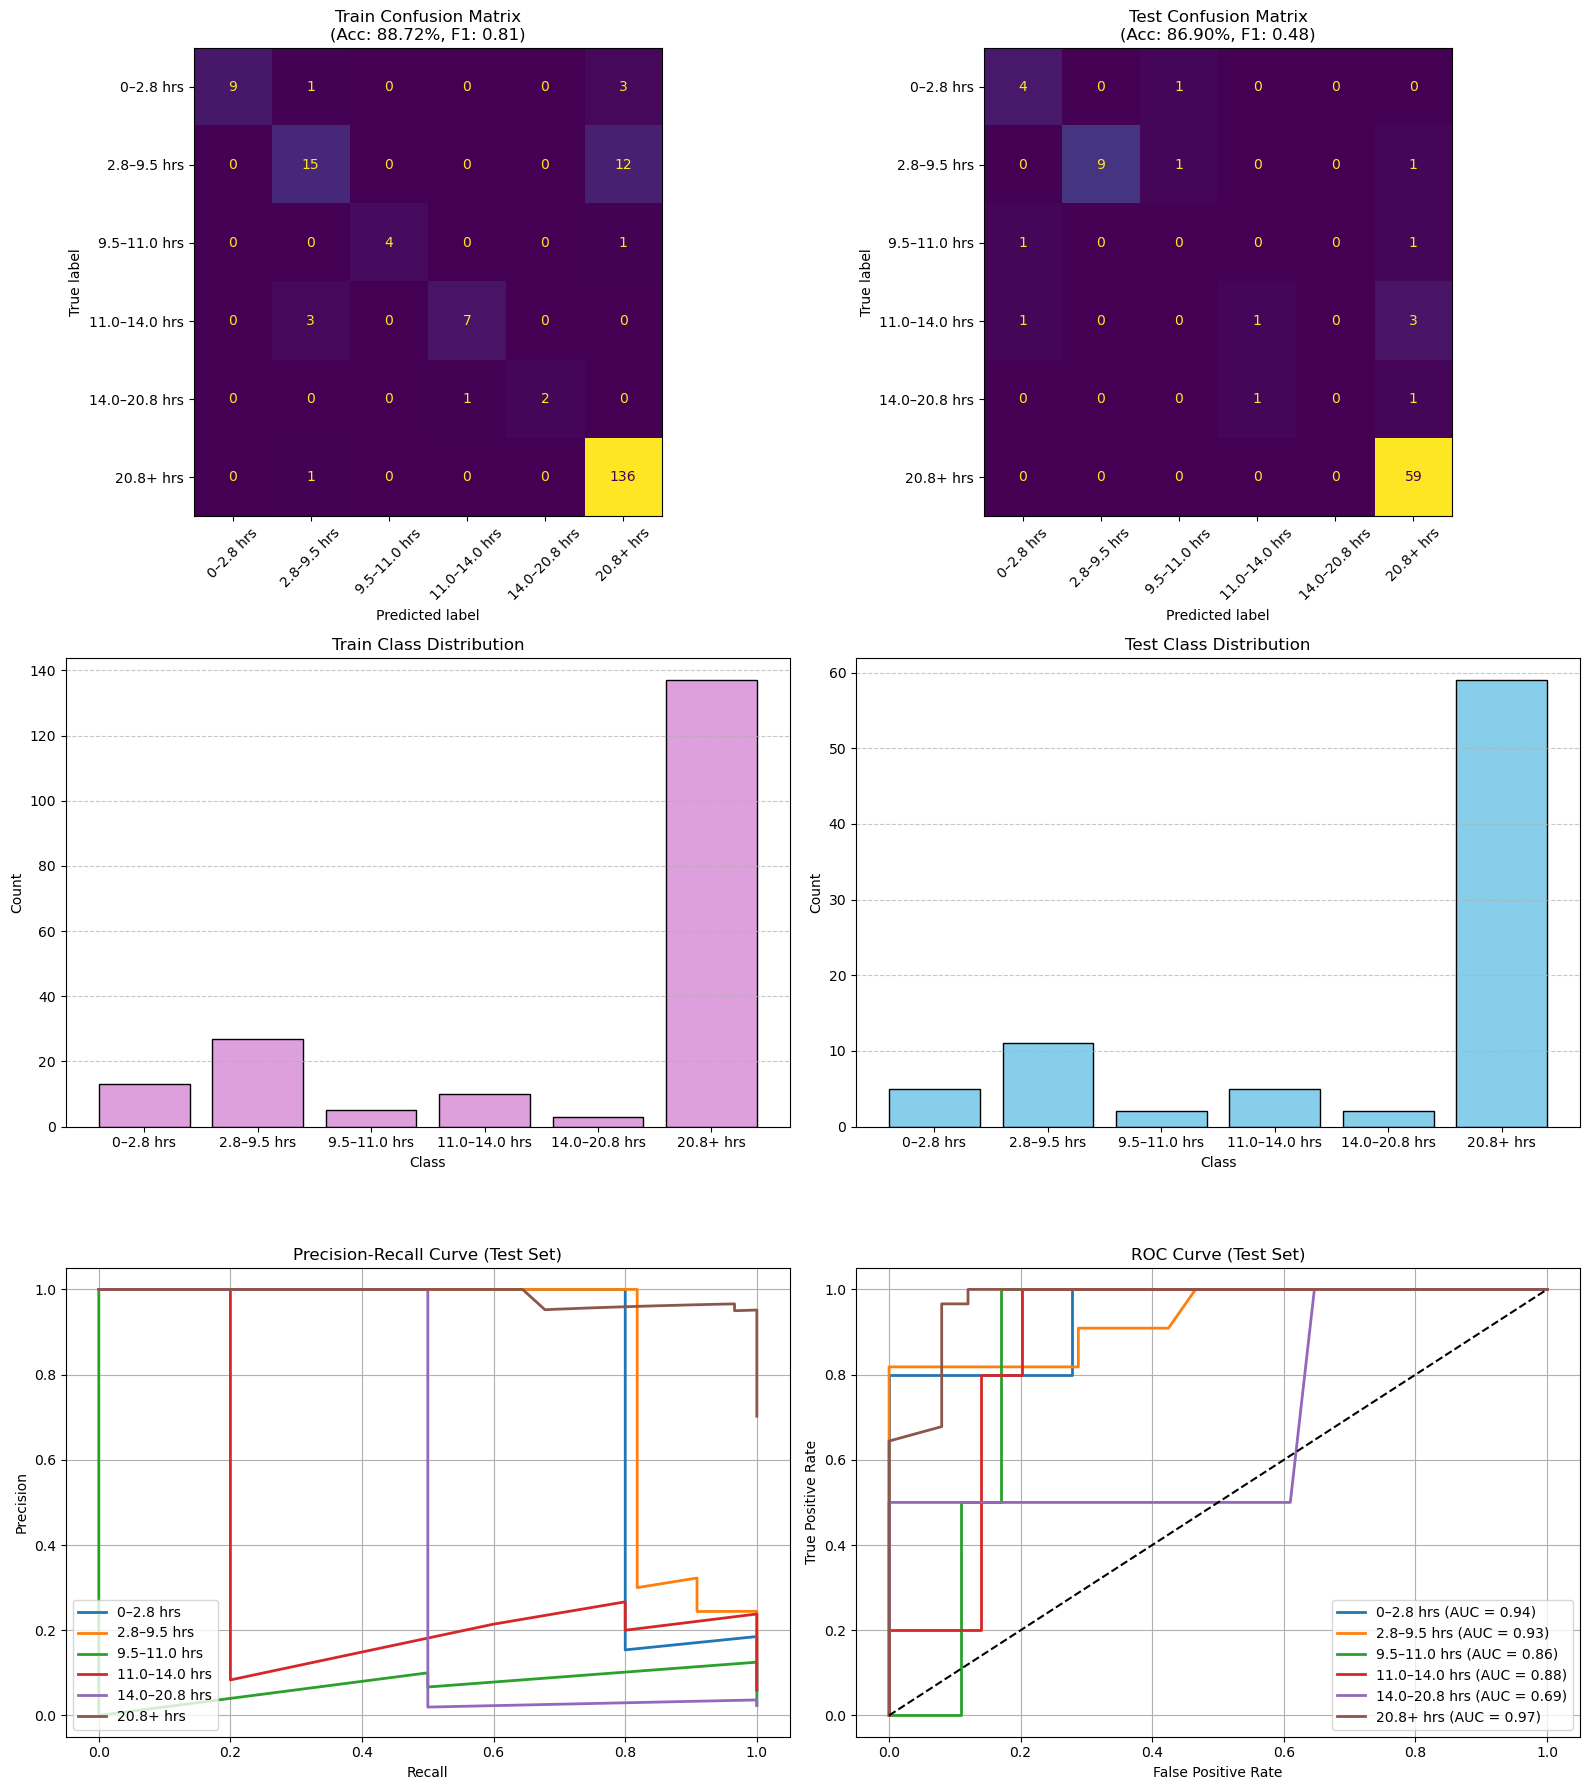


--- Region: VIC ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.83      0.56      0.67         9
  2.8–9.5 hrs       0.62      0.24      0.35        33
 9.5–11.0 hrs       0.52      0.84      0.65       127
11.0–14.0 hrs       0.79      0.62      0.70       167
14.0–20.8 hrs       0.00      0.00      0.00         4
    20.8+ hrs       0.79      0.38      0.51        29

     accuracy                           0.64       369
    macro avg       0.59      0.44      0.48       369
 weighted avg       0.67      0.64      0.62       369



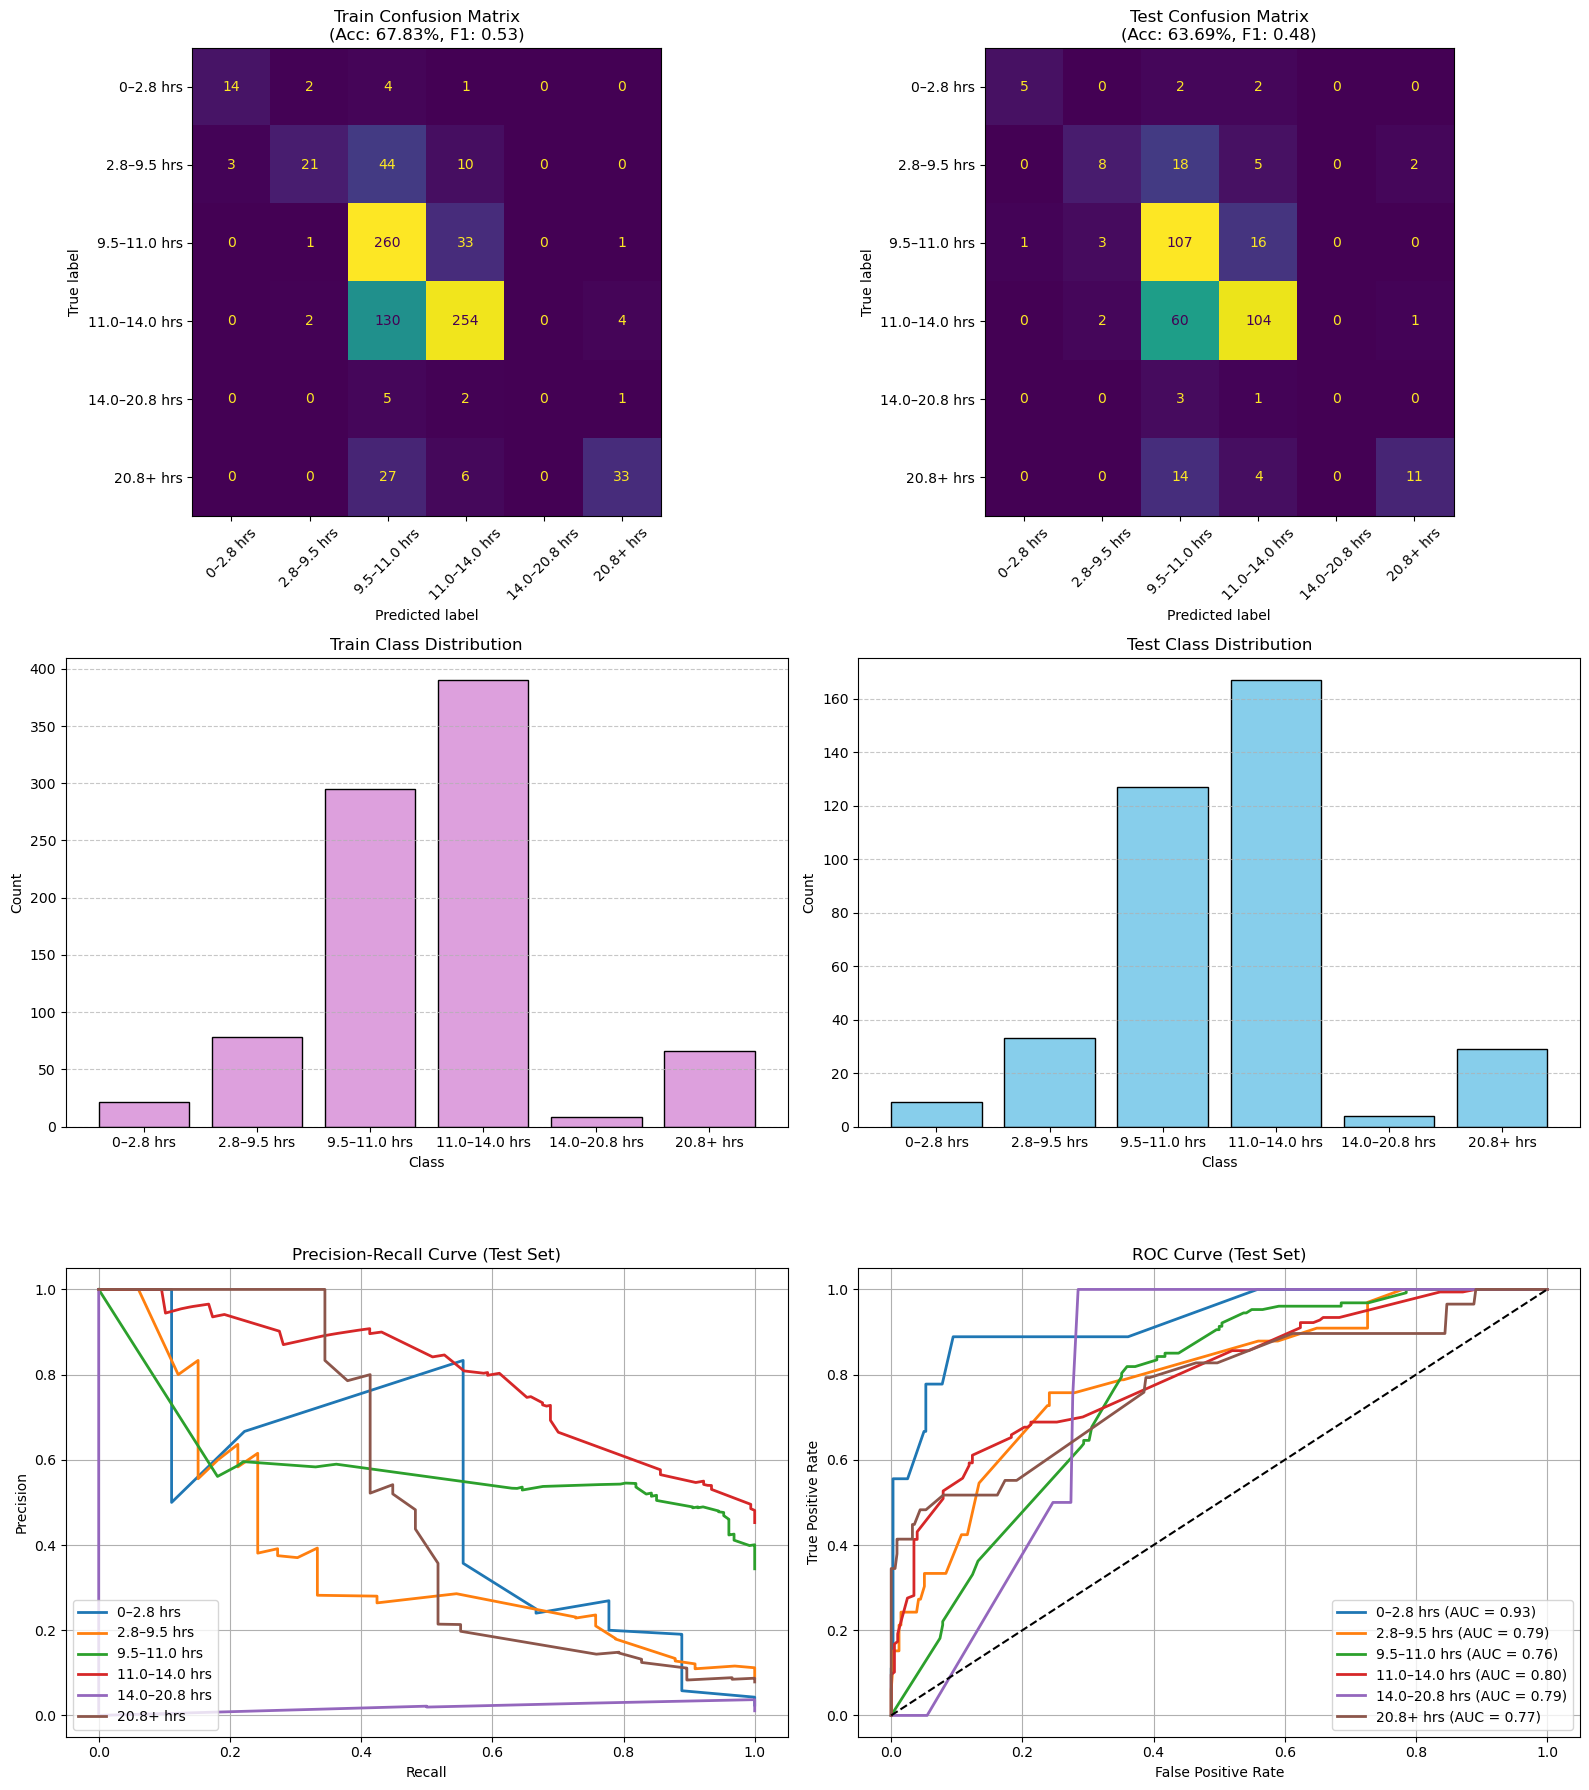


--- Region: TAS ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.57      0.57      0.57         7
  2.8–9.5 hrs       0.77      0.91      0.83        22
 9.5–11.0 hrs       0.00      0.00      0.00         1
11.0–14.0 hrs       0.00      0.00      0.00         0
14.0–20.8 hrs       0.00      0.00      0.00         0
    20.8+ hrs       1.00      0.64      0.78        11

     accuracy                           0.76        41
    macro avg       0.39      0.35      0.36        41
 weighted avg       0.78      0.76      0.75        41



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


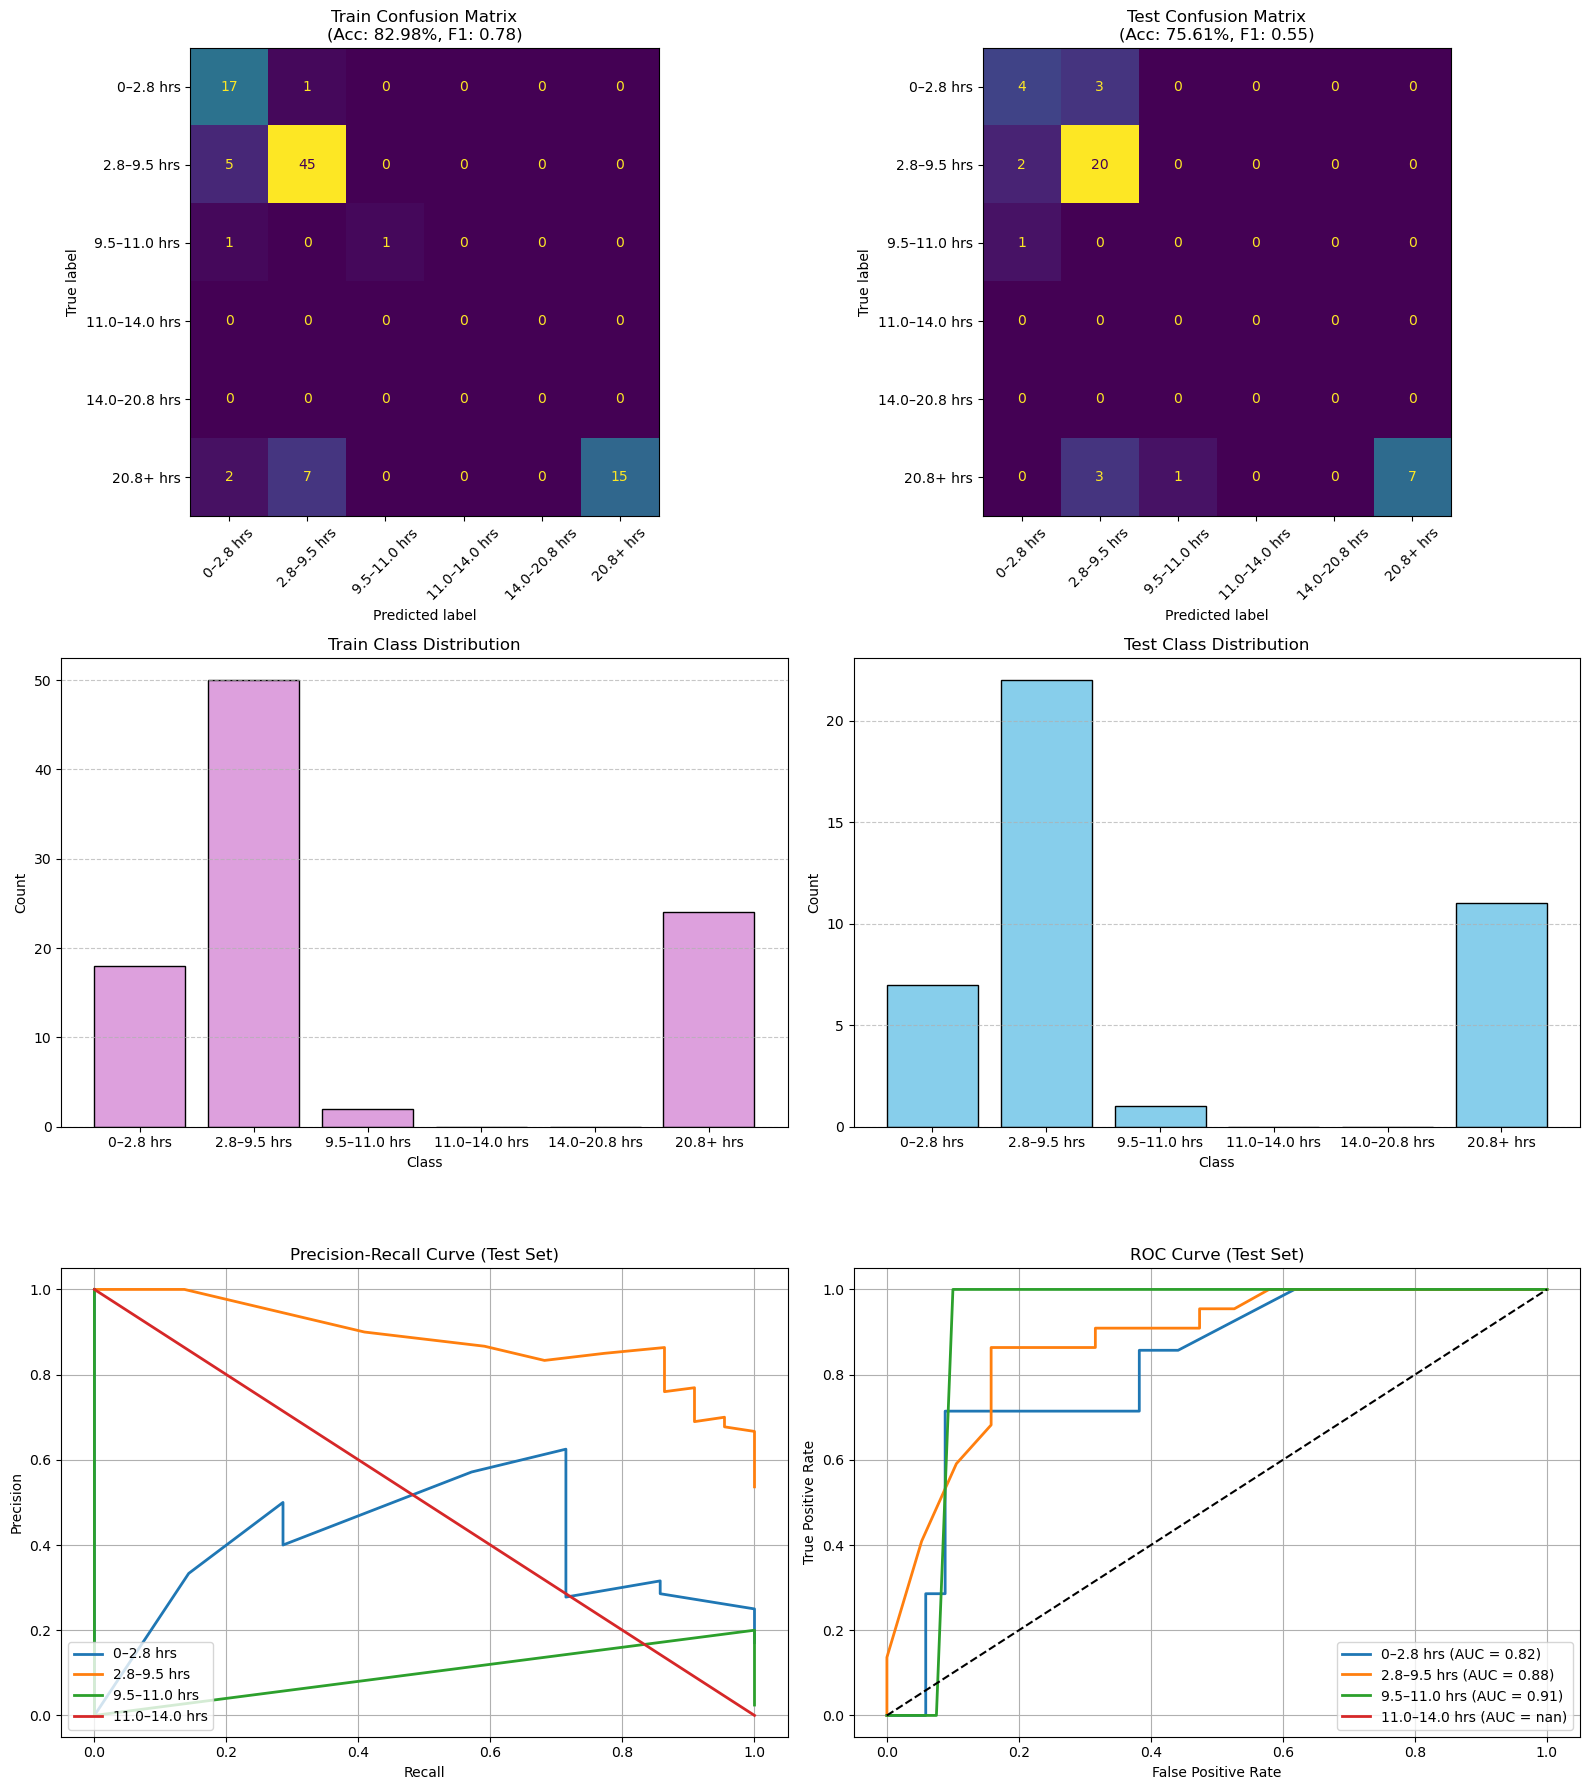


--- Region: QLD ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.50      0.60      0.55        10
  2.8–9.5 hrs       0.80      0.78      0.79        45
 9.5–11.0 hrs       1.00      0.14      0.25         7
11.0–14.0 hrs       0.00      0.00      0.00         1
14.0–20.8 hrs       0.00      0.00      0.00         0
    20.8+ hrs       0.80      0.91      0.85        44

     accuracy                           0.77       107
    macro avg       0.52      0.40      0.41       107
 weighted avg       0.78      0.77      0.75       107



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


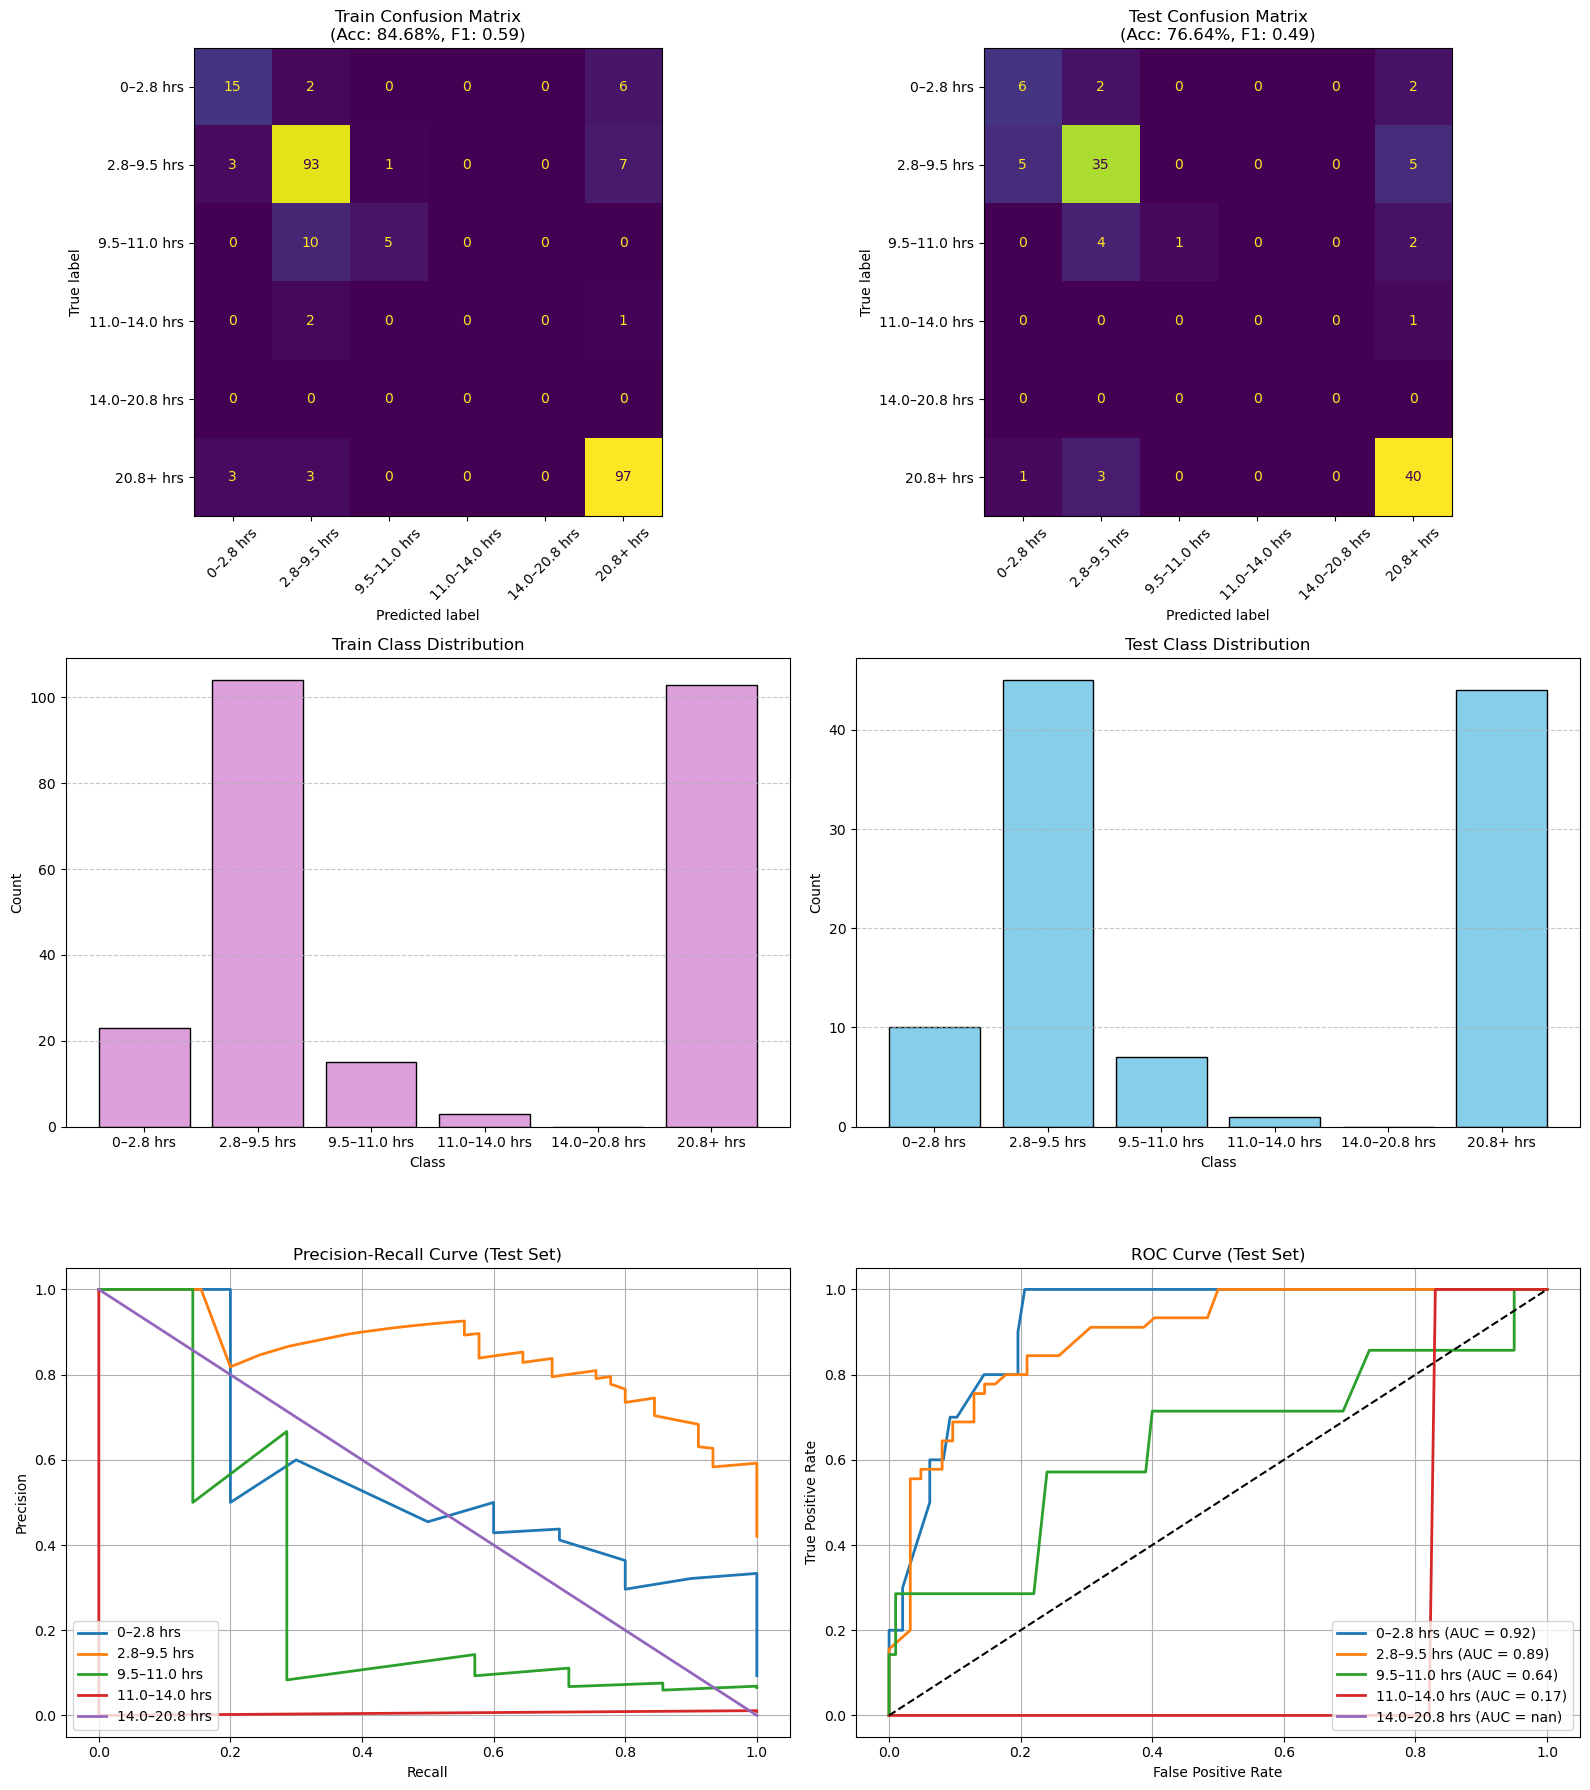


--- Region: NSW ---

Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.00      0.00      0.00         2
  2.8–9.5 hrs       0.33      0.14      0.20         7
 9.5–11.0 hrs       0.70      0.67      0.68        21
11.0–14.0 hrs       0.66      0.86      0.75        22
14.0–20.8 hrs       0.00      0.00      0.00         4
    20.8+ hrs       0.86      0.96      0.91        25

     accuracy                           0.72        81
    macro avg       0.42      0.44      0.42        81
 weighted avg       0.65      0.72      0.68        81



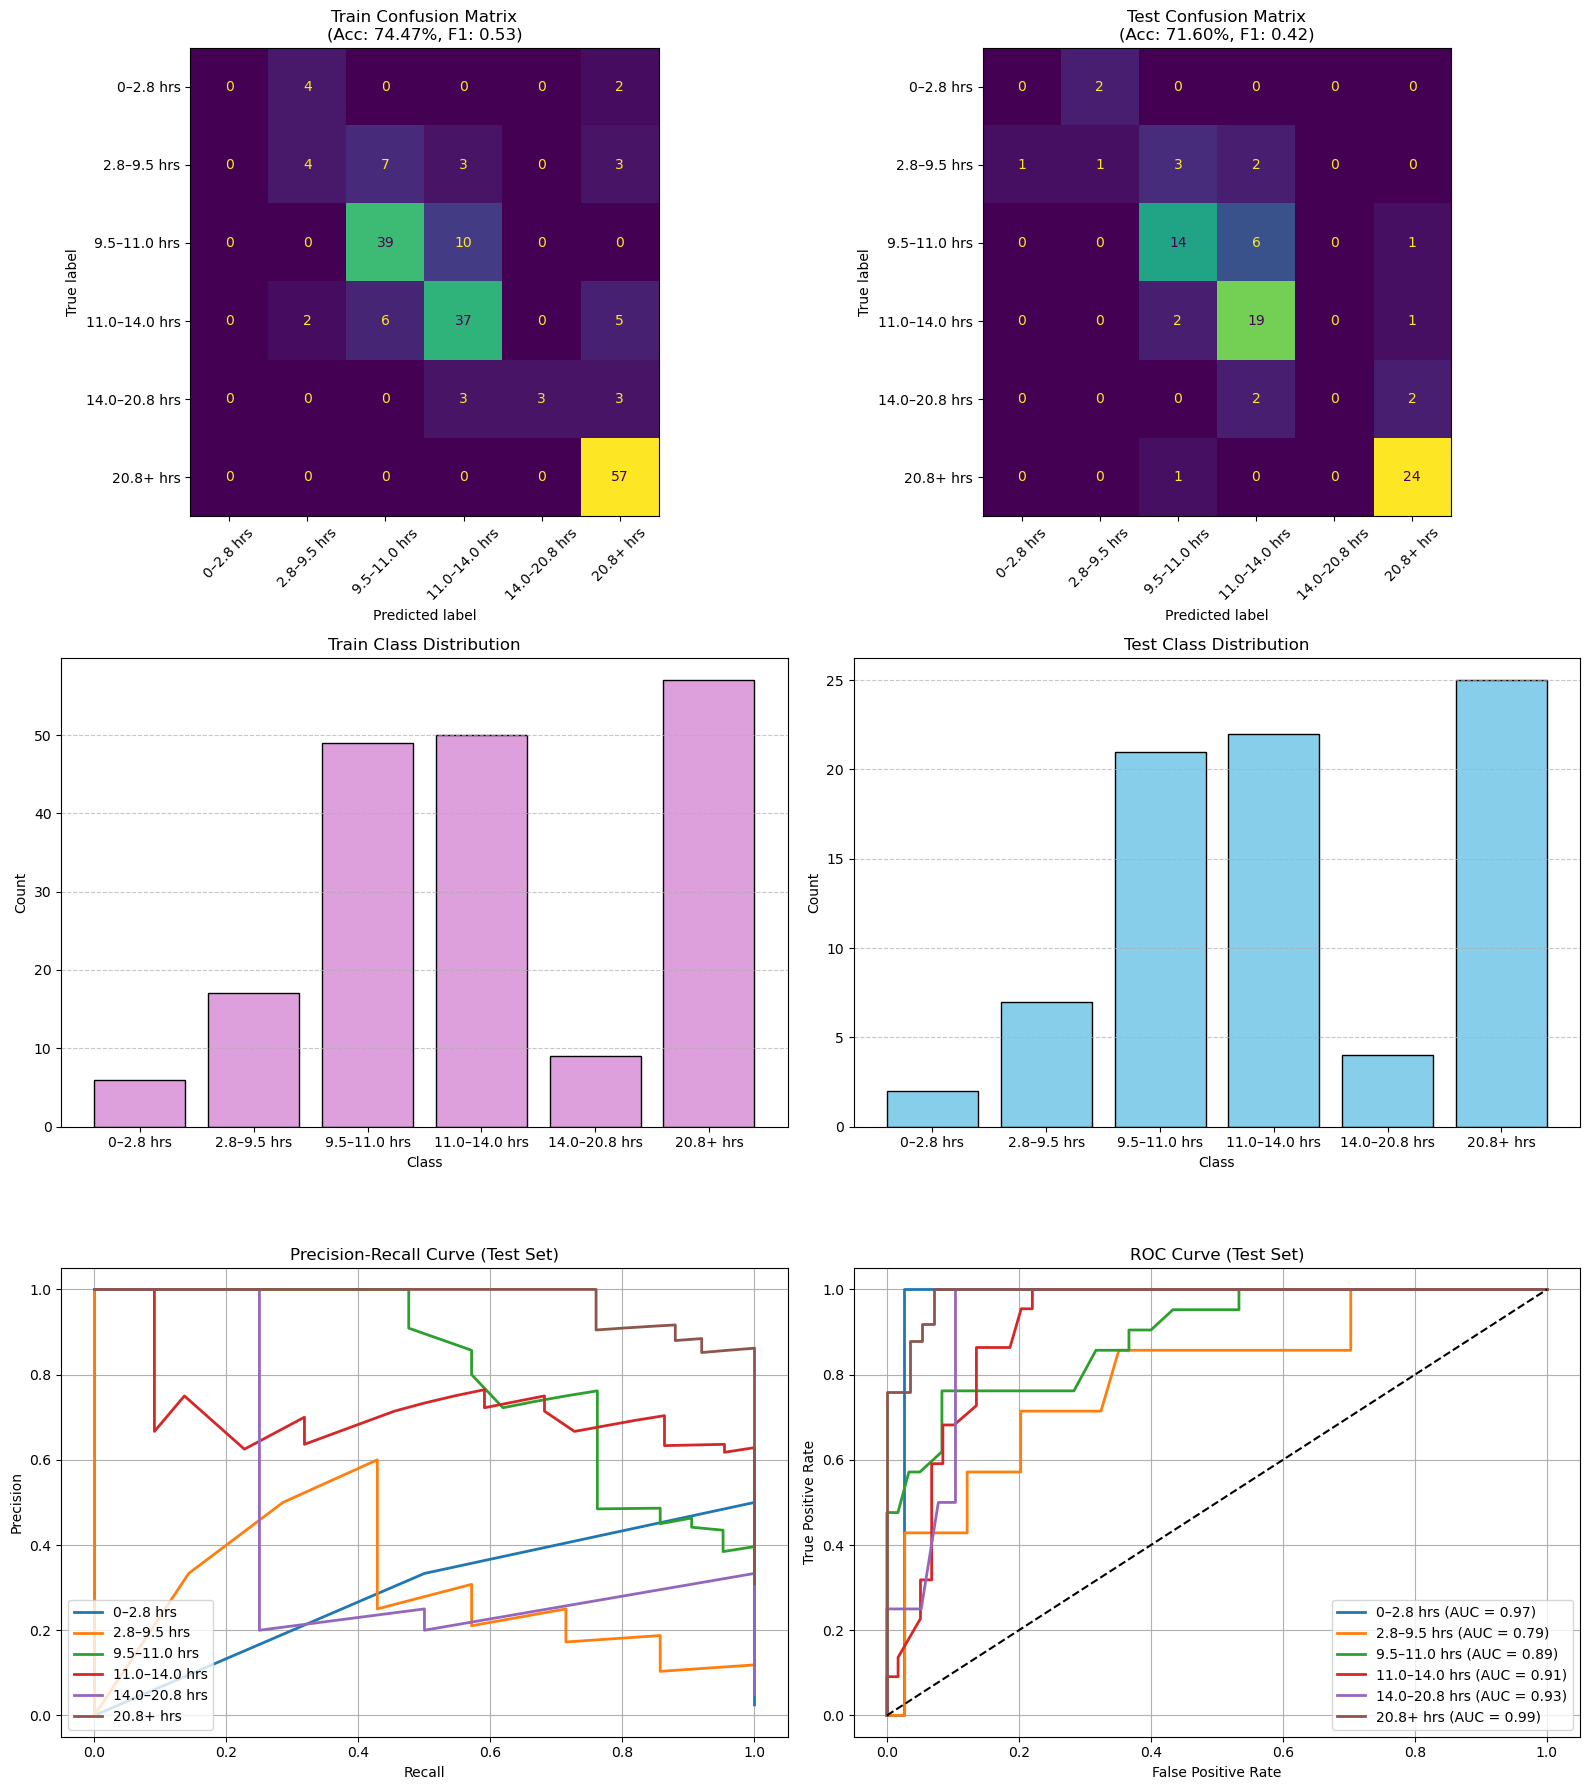

In [5]:
feature_cols = ['Recall_Day_Hours', 'Recall_Night_Hours',
    'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
    'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
target_col = 'Duration_Category'

region_models = {}
for region in df['Region'].unique():
    print(f"\n--- Region: {region} ---")
    region_df = df[df['Region'] == region].copy()
    model = train_and_evaluate_tabpfn(region_df, feature_cols, target_col)
    region_models[region] = model